In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Reading in files

These datasets were collected from FAOSTAT https://www.fao.org/faostat/en/#data

In [2]:
from os import listdir
from os.path import isfile, join
FAOfiles = [f for f in listdir('./datasets/') if isfile(join('./datasets/', f))]

In [3]:
df_dict = {}
for file in FAOfiles:
    df_dict[file[:-4]] = pd.read_csv('./datasets/'+file) #using the filenames to generate the dictionary keys to hold the dataframes
    if 'Year' in df_dict[file[:-4]].columns.to_list():
        df_dict[file[:-4]]['Year'] = pd.to_datetime(df_dict[file[:-4]]['Year'], format='%Y') #changing it to datetime is probably pointless but I like to recognise dates as dates

In [4]:
from os import path, makedirs
if path.exists('./graphs/'):
    print('graphs folder exists')
else:
    makedirs('./graphs/')

graphs folder exists


## Datasets of interest
I think crops and livestock QCL (Production: Crops and livestock products) and TCL (Trade: Crops and livestock products) are my two most important datasets so we'll focus on them for now

In [5]:
df_QCL = df_dict['FAOSTAT_data_en_IRL_SPA_crops_and_livestock_products_QCL'] #I don't need to do this but renaming means less typing
df_TCL = df_dict['FAOSTAT_data_en_IRL_SPA_crops_and_livestock_products_TCL']

In [6]:
#hello again. Making sure I haven't lost my variables
chicken_item = []
grains_item = []
for item in df_QCL['Item'].unique():
    if 'hicken' in item:
        chicken_item.append(item)
    else:
        grains_item.append(item)

In [7]:
#and reminding myself what they say
print('Chicken list: ', chicken_item)
print('Grains list: ', grains_item)

Chicken list:  ['Chickens', 'Meat of chickens, fresh or chilled']
Grains list:  ['Barley', 'Cereals n.e.c.', 'Maize (corn)', 'Mixed grain', 'Oats', 'Soya beans', 'Sunflower seed', 'Wheat', 'Millet']


Grab that population dataset so we can do some per capita calculations

In [8]:
df_pop = df_dict['FAOSTAT_data_en_IRL_SPA_annual_population']

In [9]:
df_Qirl = df_QCL[df_QCL['Area'] == 'Ireland']

In [10]:
df_Qirl['Item'].unique()

array(['Barley', 'Cereals n.e.c.', 'Chickens', 'Maize (corn)',
       'Meat of chickens, fresh or chilled', 'Mixed grain', 'Oats',
       'Soya beans', 'Sunflower seed', 'Wheat'], dtype=object)

In [11]:
unwanted = ['Mixed grain', 'Cereals n.e.c.','Maize (corn)','Soya beans', 'Sunflower seed']

In [12]:
df_Qirl = df_Qirl[~df_Qirl['Item'].isin(unwanted)]

In [13]:
wanted = df_Qirl['Item'].unique()
wanted # for consistency in the spanish dataset. Or maybe it doesn't matter? 

array(['Barley', 'Chickens', 'Meat of chickens, fresh or chilled', 'Oats',
       'Wheat'], dtype=object)

In [14]:
df_Qirl['Item Element'] = df_Qirl['Item'] +' ' + df_Qirl['Element'] + ' ' + df_Qirl['Unit'] #I don't know why this is wrong? Is there more approriate way to concat strings across columns?

In [15]:
df_Qirl_pivot = df_Qirl.pivot(index='Year', columns='Item Element')['Value']

In [16]:
df_pop_irl_pivot = df_pop[df_pop['Area']=='Ireland'].pivot(index='Year', columns='Element', values='Value')

In [17]:
df_irl_merged = pd.merge(df_pop_irl_pivot, df_Qirl_pivot, on='Year') #so I can do those per capita calculations

In [18]:
#chickens (animal numbers) killed per person in Ireland
df_irl_merged['Meat of chicken Producing Animals/Slaughtered per capita head/person'] = df_irl_merged['Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head'] / df_irl_merged['Total Population - Both sexes']

In [19]:
#chicken kg per person in Ireland
df_irl_merged['Meat of chickens, fresh or chilled Production per capita kg/person'] = df_irl_merged['Meat of chickens, fresh or chilled Production tonnes'] / df_irl_merged['Total Population - Both sexes']

In [20]:
df_Qspa = df_QCL[df_QCL['Area'] == 'Spain']

In [21]:
df_Qspa = df_Qspa[df_Qspa['Item'].isin(wanted)]

In [22]:
df_Qspa['Item Element'] = df_Qspa['Item'] +' ' + df_Qspa['Element'] + ' ' + df_Qspa['Unit']

In [23]:
df_Qspa_pivot = df_Qspa.pivot(index='Year', columns='Item Element')['Value']

In [24]:
df_pop_spa_pivot = df_pop[df_pop['Area']=='Spain'].pivot(index='Year', columns='Element', values='Value')

In [25]:
df_spa_merged = pd.merge(df_pop_spa_pivot, df_Qspa_pivot, on='Year')

In [26]:
df_spa_merged['Meat of chicken Producing Animals/Slaughtered per capita head/person'] = df_spa_merged['Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head'] / df_spa_merged['Total Population - Both sexes']

In [27]:
#chicken kg per person in Spain
df_spa_merged['Meat of chickens, fresh or chilled Production per capita kg/person'] = df_spa_merged['Meat of chickens, fresh or chilled Production tonnes'] / df_spa_merged['Total Population - Both sexes']

In [28]:
df_TCL['Item Element']  = df_TCL['Item'] + ' ' + df_TCL['Element'] + ' ' + df_TCL['Unit']

In [29]:
vc_irl = df_TCL[df_TCL['Area']=='Ireland']['Item Element'].value_counts()
vc_irl #value counts of product element based on ireland

Barley Import Quantity tonnes                               61
Maize (corn) Export Quantity tonnes                         61
Millet Import Value 1000 US$                                61
Millet Import Quantity tonnes                               61
Meat of chickens, fresh or chilled Export Value 1000 US$    61
                                                            ..
Barley flour and grits Export Quantity tonnes                6
Cereals n.e.c. Export Quantity tonnes                        6
Cereals n.e.c. Export Value 1000 US$                         6
Mixed grain Import Quantity tonnes                           3
Mixed grain Import Value 1000 US$                            3
Name: Item Element, Length: 86, dtype: int64

In [30]:
vc_irl[vc_irl<20] # lowest value count elements

Poultry fat, rendered Export Value 1000 US$      8
Bran of cereals n.e.c. Import Quantity tonnes    8
Barley flour and grits Import Quantity tonnes    8
Barley flour and grits Import Value 1000 US$     8
Cereals n.e.c. Import Value 1000 US$             8
Cereals n.e.c. Import Quantity tonnes            8
Millet Export Quantity tonnes                    8
Poultry fat, rendered Export Quantity tonnes     8
Millet Export Value 1000 US$                     8
Bran of cereals n.e.c. Import Value 1000 US$     8
Poultry fat, rendered Import Value 1000 US$      8
Poultry fat, rendered Import Quantity tonnes     8
Bran of cereals n.e.c. Export Quantity tonnes    7
Bran of cereals n.e.c. Export Value 1000 US$     7
Barley flour and grits Export Value 1000 US$     6
Barley flour and grits Export Quantity tonnes    6
Cereals n.e.c. Export Quantity tonnes            6
Cereals n.e.c. Export Value 1000 US$             6
Mixed grain Import Quantity tonnes               3
Mixed grain Import Value 1000 U

In [31]:
keep = list(vc_irl[vc_irl>20].index) #keep values with greater than 20 occurences

In [32]:
df_TCL_trim = df_TCL[df_TCL['Item Element'].isin(keep)] # apply to whole dataset

In [33]:
df_TCL_irl = df_TCL[df_TCL['Area']=='Ireland']
df_TCL_spa = df_TCL[df_TCL['Area']=='Spain']

In [34]:
df_TCL_irl_pivot = df_TCL_irl.pivot(index='Year', columns='Item Element', values='Value')
df_TCL_spa_pivot = df_TCL_spa.pivot(index='Year', columns='Item Element', values='Value')

In [35]:
df_irl_merged = pd.merge(df_irl_merged, df_TCL_irl_pivot, on='Year')
df_spa_merged = pd.merge(df_spa_merged, df_TCL_spa_pivot, on='Year')

All of the above cells are taken from CA2-1.ipynb so sorry for the lack of explanation. I just wanted to recreate the steps to get to the same two datasets.

# Machine Learning

### What do chickens eat?

Chickens are omnivorous animals, which means that they eat a variety of plant and animal-based foods. The specific diet of a chicken will depend on its age, size, and purpose (such as laying eggs or being raised for meat). Here are some common foods that chickens might eat:

1.    Grains: Chickens will often eat a variety of grains, including corn, wheat, oats, and barley. These grains can be fed to chickens in whole form or ground into a meal.

2.    Seeds and nuts: Chickens will also eat a variety of seeds and nuts, such as sunflower seeds, pumpkin seeds, and almonds.

3.    Vegetables and fruits: Chickens will eat many types of vegetables and fruits, such as leafy greens, peas, beans, carrots, apples, and berries.

4.    Insects: Chickens will also supplement their diet with insects, such as beetles, worms, and grasshoppers.

5.    Commercial feed: In addition to these natural foods, chickens may also be fed a commercial feed mix, which is a formulated blend of grains, proteins, vitamins, and minerals.

It is important to provide chickens with a balanced diet that meets their nutritional needs, as this can affect their health, egg production, and overall well-being.

### Do grain import prices affect the consumer prices of chicken

Grain import prices can potentially affect the consumer prices of chicken, as grain is a major component of the diet of chickens raised for meat or egg production. If grain prices increase, this can lead to higher feed costs for chicken producers, which could in turn lead to higher consumer prices for chicken. However, it is worth noting that there are many other factors that can also influence the consumer prices of chicken, such as the cost of labor, transportation, and other inputs, as well as market demand and supply. As a result, the relationship between grain import prices and consumer prices of chicken is likely to be complex and may vary over time.

Okay, realising we don't have consumer price data for poultry. We just have the consumer price index, but that is for all food, not chicken specifally. However, we do have producer prices. So, let's see what factors affect producer prices of chicken meat.

In [36]:
df_prod_price = df_dict['FAOSTAT_data_en__IRL_SPA_producer_prices'][df_dict['FAOSTAT_data_en__IRL_SPA_producer_prices']['Area']=='Ireland']

In [37]:
df_prod_price

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1991,1991-01-01,7021,Annual value,USD,173.80,A,Official figure
1,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1992,1992-01-01,7021,Annual value,USD,173.50,A,Official figure
2,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1993,1993-01-01,7021,Annual value,USD,140.30,A,Official figure
3,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1994,1994-01-01,7021,Annual value,USD,130.10,A,Official figure
4,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1995,1995-01-01,7021,Annual value,USD,168.30,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,PP,Producer Prices,372,Ireland,5539,Producer Price Index (2014-2016 = 100),0111,Wheat,2017,2017-01-01,7021,Annual value,NaN,95.99,I,Imputed value
317,PP,Producer Prices,372,Ireland,5539,Producer Price Index (2014-2016 = 100),0111,Wheat,2018,2018-01-01,7021,Annual value,NaN,131.16,I,Imputed value
318,PP,Producer Prices,372,Ireland,5539,Producer Price Index (2014-2016 = 100),0111,Wheat,2019,2019-01-01,7021,Annual value,NaN,96.00,I,Imputed value
319,PP,Producer Prices,372,Ireland,5539,Producer Price Index (2014-2016 = 100),0111,Wheat,2020,2020-01-01,7021,Annual value,NaN,111.38,I,Imputed value


As much as it burns me, we're going to stick with USD, as the trade prices are also in USD so the units are consistent.

In [38]:
print(df_prod_price['Item'].unique(), df_prod_price['Element'].unique())

['Barley' 'Cereals n.e.c.' 'Maize (corn)'
 'Meat of chickens, fresh or chilled'
 'Meat of chickens, fresh or chilled (biological)' 'Oats' 'Wheat'] ['Producer Price (USD/tonne)' 'Producer Price Index (2014-2016 = 100)']


In [39]:
df_prod_price = df_prod_price[df_prod_price['Element']=='Producer Price (USD/tonne)']

In [40]:
print(df_prod_price['Item'].unique(), df_prod_price['Element'].unique()) #where did maize go? whatever, we barely grow it

['Barley' 'Meat of chickens, fresh or chilled'
 'Meat of chickens, fresh or chilled (biological)' 'Oats' 'Wheat'] ['Producer Price (USD/tonne)']


In [41]:
df_prod_price

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1991,1991-01-01,7021,Annual value,USD,173.8,A,Official figure
1,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1992,1992-01-01,7021,Annual value,USD,173.5,A,Official figure
2,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1993,1993-01-01,7021,Annual value,USD,140.3,A,Official figure
3,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1994,1994-01-01,7021,Annual value,USD,130.1,A,Official figure
4,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1995,1995-01-01,7021,Annual value,USD,168.3,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0111,Wheat,2016,2016-01-01,7021,Annual value,USD,154.6,A,Official figure
286,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0111,Wheat,2017,2017-01-01,7021,Annual value,USD,168.2,A,Official figure
287,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0111,Wheat,2018,2018-01-01,7021,Annual value,USD,240.3,A,Official figure
288,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0111,Wheat,2019,2019-01-01,7021,Annual value,USD,166.7,A,Official figure


In [42]:
df_prod_price['Item Element'] = df_prod_price['Item'] + ' ' + df_prod_price['Element']

C:\Users\Juliet\AppData\Local\Temp\ipykernel_5496\1211386011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_price['Item Element'] = df_prod_price['Item'] + ' ' + df_prod_price['Element']


In [43]:
df_prod_price.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description,Item Element
0,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1991,1991-01-01,7021,Annual value,USD,173.8,A,Official figure,Barley Producer Price (USD/tonne)
1,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1992,1992-01-01,7021,Annual value,USD,173.5,A,Official figure,Barley Producer Price (USD/tonne)
2,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1993,1993-01-01,7021,Annual value,USD,140.3,A,Official figure,Barley Producer Price (USD/tonne)
3,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1994,1994-01-01,7021,Annual value,USD,130.1,A,Official figure,Barley Producer Price (USD/tonne)
4,PP,Producer Prices,372,Ireland,5532,Producer Price (USD/tonne),0115,Barley,1995,1995-01-01,7021,Annual value,USD,168.3,A,Official figure,Barley Producer Price (USD/tonne)


In [44]:
df_prod_price_pivot = df_prod_price.pivot(index='Year', columns='Item Element', values='Value')

In [45]:
df_prod_price_pivot

Item Element,Barley Producer Price (USD/tonne),"Meat of chickens, fresh or chilled (biological) Producer Price (USD/tonne)","Meat of chickens, fresh or chilled Producer Price (USD/tonne)",Oats Producer Price (USD/tonne),Wheat Producer Price (USD/tonne)
Year,,,,,
1991-01-01,173.8,1142.7,1368.1,169.0,185.1
1992-01-01,173.5,1211.4,NaN,187.2,185.5
1993-01-01,140.3,976.0,NaN,162.4,161.0
1994-01-01,130.1,952.7,NaN,124.1,137.6
1995-01-01,168.3,1003.6,1202.4,158.7,184.4
1996-01-01,145.6,1020.8,NaN,145.6,150.4
1997-01-01,115.2,976.3,NaN,115.2,118.2
1998-01-01,106.8,885.7,1060.8,111.1,113.9
1999-01-01,110.9,779.2,NaN,115.0,115.0


In [46]:
#I don't understand the difference between 'biological' and not but this column is nearly empty so. Drop.
df_prod_price_pivot.drop('Meat of chickens, fresh or chilled Producer Price (USD/tonne)', axis=1, inplace=True)

In [47]:
df_prod_price_pivot # Oh. This chicken data only goes from 1991 to 2012?? I can't build a model with that as my target variable

Item Element,Barley Producer Price (USD/tonne),"Meat of chickens, fresh or chilled (biological) Producer Price (USD/tonne)",Oats Producer Price (USD/tonne),Wheat Producer Price (USD/tonne)
Year,,,,
1991-01-01,173.8,1142.7,169.0,185.1
1992-01-01,173.5,1211.4,187.2,185.5
1993-01-01,140.3,976.0,162.4,161.0
1994-01-01,130.1,952.7,124.1,137.6
1995-01-01,168.3,1003.6,158.7,184.4
1996-01-01,145.6,1020.8,145.6,150.4
1997-01-01,115.2,976.3,115.2,118.2
1998-01-01,106.8,885.7,111.1,113.9
1999-01-01,110.9,779.2,115.0,115.0


Wahh. I was going to do price but not enough data. What should be my target variable now?

In [48]:
df_irl_merged

,Rural population,Total Population - Both sexes,Total Population - Female,Total Population - Male,Urban population,Barley Area harvested ha,Barley Production tonnes,Barley Yield hg/ha,Chickens Stocks 1000 Head,"Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head",...,Soya beans Import Quantity tonnes,Soya beans Import Value 1000 US$,Sunflower seed Export Quantity tonnes,Sunflower seed Export Value 1000 US$,Sunflower seed Import Quantity tonnes,Sunflower seed Import Value 1000 US$,Wheat Export Quantity tonnes,Wheat Export Value 1000 US$,Wheat Import Quantity tonnes,Wheat Import Value 1000 US$
Year,,,,,,,,,,,,,,,,,,,,,
1961-01-01,1539.928,2807.005,1396.739,1410.265,1280.110,146373.0,515400.0,35211.0,7258.0,8750.0,...,0.00,0.0,0.00,0.0,0.00,0.0,146626.00,7334.0,262579.00,18764.0
1962-01-01,1536.686,2813.067,1400.138,1412.929,1288.262,164219.0,603200.0,36731.0,6954.0,8400.0,...,0.00,0.0,0.00,0.0,0.00,0.0,32076.00,1687.0,136920.00,10194.0
1963-01-01,1536.216,2824.089,1405.725,1418.364,1298.803,173608.0,588900.0,33921.0,7050.0,9550.0,...,19.00,1.0,0.00,0.0,0.00,0.0,57051.00,2828.0,232558.00,17097.0
1964-01-01,1536.905,2837.436,1412.455,1424.982,1310.435,183644.0,550699.0,29987.0,6902.0,10500.0,...,0.00,0.0,0.00,0.0,0.00,0.0,150.00,9.0,171079.00,12460.0
1965-01-01,1537.713,2852.401,1420.136,1432.265,1322.242,187790.0,615730.0,32788.0,8276.0,11300.0,...,1160.00,110.0,0.00,0.0,0.00,0.0,0.00,0.0,329927.00,22752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,1764.335,4771.854,2409.471,2362.383,2997.322,180186.0,1505811.0,83570.0,15504.0,86116.0,...,45518.72,14038.0,22.49,84.0,3088.87,1944.0,13684.27,3265.0,314040.35,60107.0
2018-01-01,1769.220,4834.507,2440.194,2394.313,3034.528,185210.0,1181560.0,63796.0,NaN,90059.0,...,29902.26,10617.0,22.83,93.0,4317.18,2438.0,20135.31,4828.0,455658.16,101796.0
2019-01-01,1773.798,4896.019,2470.880,2425.139,3073.341,179360.0,1479600.0,82493.0,NaN,96247.0,...,27003.35,9807.0,26.02,94.0,3938.09,3057.0,26241.10,6056.0,292921.90,62281.0


In [49]:
print(df_irl_merged.columns.tolist())

['Rural population', 'Total Population - Both sexes', 'Total Population - Female', 'Total Population - Male', 'Urban population', 'Barley Area harvested ha', 'Barley Production tonnes', 'Barley Yield hg/ha', 'Chickens Stocks 1000 Head', 'Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head', 'Meat of chickens, fresh or chilled Production tonnes', 'Meat of chickens, fresh or chilled Yield/Carcass Weight 0.1g/An', 'Oats Area harvested ha', 'Oats Production tonnes', 'Oats Yield hg/ha', 'Wheat Area harvested ha', 'Wheat Production tonnes', 'Wheat Yield hg/ha', 'Meat of chicken Producing Animals/Slaughtered per capita head/person', 'Meat of chickens, fresh or chilled Production per capita kg/person', 'Barley Export Quantity tonnes', 'Barley Export Value 1000 US$', 'Barley Import Quantity tonnes', 'Barley Import Value 1000 US$', 'Barley flour and grits Export Quantity tonnes', 'Barley flour and grits Export Value 1000 US$', 'Barley flour and grits Import Quantity tonnes

In [50]:
#what are all my chicken columns
for column in df_irl_merged.columns.tolist():
    if 'chicken' in column.lower():
        print(column)

Chickens Stocks 1000 Head
Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head
Meat of chickens, fresh or chilled Production tonnes
Meat of chickens, fresh or chilled Yield/Carcass Weight 0.1g/An
Meat of chicken Producing Animals/Slaughtered per capita head/person
Meat of chickens, fresh or chilled Production per capita kg/person
Chickens Export Quantity 1000 Head
Chickens Export Value 1000 US$
Chickens Import Quantity 1000 Head
Chickens Import Value 1000 US$
Edible offals and liver of chickens and guinea fowl, fresh, chilled or frozen Export Quantity tonnes
Edible offals and liver of chickens and guinea fowl, fresh, chilled or frozen Export Value 1000 US$
Edible offals and liver of chickens and guinea fowl, fresh, chilled or frozen Import Quantity tonnes
Edible offals and liver of chickens and guinea fowl, fresh, chilled or frozen Import Value 1000 US$
Meat of chickens, fresh or chilled Export Quantity tonnes
Meat of chickens, fresh or chilled Export Value 1000 U

Target aquired: 'Meat of chickens, fresh or chilled Export Value 1000 US$'. Or USD/tonnes for an actual price unit.

Let's inspect column names of df_irl_merged again so I can choose which columns to keep as features for the ML dataset.

In [51]:
grains_item # from much earlier dataset - df_QCL['Item']

['Barley',
 'Cereals n.e.c.',
 'Maize (corn)',
 'Mixed grain',
 'Oats',
 'Soya beans',
 'Sunflower seed',
 'Wheat',
 'Millet']

In [52]:
for column in df_irl_merged.columns.tolist():
    for grain in grains_item:
        if grain.lower() in column.lower():
            print(column)

Barley Area harvested ha
Barley Production tonnes
Barley Yield hg/ha
Oats Area harvested ha
Oats Production tonnes
Oats Yield hg/ha
Wheat Area harvested ha
Wheat Production tonnes
Wheat Yield hg/ha
Barley Export Quantity tonnes
Barley Export Value 1000 US$
Barley Import Quantity tonnes
Barley Import Value 1000 US$
Barley flour and grits Export Quantity tonnes
Barley flour and grits Export Value 1000 US$
Barley flour and grits Import Quantity tonnes
Barley flour and grits Import Value 1000 US$
Barley, pearled Export Quantity tonnes
Barley, pearled Export Value 1000 US$
Barley, pearled Import Quantity tonnes
Barley, pearled Import Value 1000 US$
Bran of cereals n.e.c. Export Quantity tonnes
Bran of cereals n.e.c. Export Value 1000 US$
Bran of cereals n.e.c. Import Quantity tonnes
Bran of cereals n.e.c. Import Value 1000 US$
Bran of wheat Export Quantity tonnes
Bran of wheat Export Value 1000 US$
Bran of wheat Import Quantity tonnes
Bran of wheat Import Value 1000 US$
Cake of  soya beans 

In [53]:
for column in df_irl_merged.columns.tolist(): #it's just easier to read this way
    print(column)

Rural population
Total Population - Both sexes
Total Population - Female
Total Population - Male
Urban population
Barley Area harvested ha
Barley Production tonnes
Barley Yield hg/ha
Chickens Stocks 1000 Head
Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head
Meat of chickens, fresh or chilled Production tonnes
Meat of chickens, fresh or chilled Yield/Carcass Weight 0.1g/An
Oats Area harvested ha
Oats Production tonnes
Oats Yield hg/ha
Wheat Area harvested ha
Wheat Production tonnes
Wheat Yield hg/ha
Meat of chicken Producing Animals/Slaughtered per capita head/person
Meat of chickens, fresh or chilled Production per capita kg/person
Barley Export Quantity tonnes
Barley Export Value 1000 US$
Barley Import Quantity tonnes
Barley Import Value 1000 US$
Barley flour and grits Export Quantity tonnes
Barley flour and grits Export Value 1000 US$
Barley flour and grits Import Quantity tonnes
Barley flour and grits Import Value 1000 US$
Barley, pearled Export Quantity to

### What is cake of soya bean

Soybean cake, also known as soybean meal or soymeal, is a byproduct of soybean oil production. It is made by grinding up the residue of soybeans after the oil has been extracted, and it is a rich source of protein, fiber, and other nutrients.

Soybean cake is commonly used as a feed ingredient for livestock, particularly for poultry and pigs. It is a popular choice due to its high protein content, which can help to support muscle growth and development. Soybean cake can also be used as a protein source in aquaculture and as a fertilizer in agriculture.

In addition to its use as a feed and fertilizer, soybean cake can also be used as a source of protein in human food products, such as protein bars and protein powders. It is also sometimes used as an ingredient in other products, such as plastics and adhesives.

Soybean cake is typically sold in a dry, pelleted form, and it can be stored for long periods of time without spoiling. It is usually transported and handled in bulk, and it is often blended with other feed ingredients to create a balanced diet for livestock.

### What is cake of maize

Maize cake, also known as corn cake or cornmeal, is a byproduct of maize processing. It is made by grinding up the residue of maize after the grain has been removed, and it is a rich source of protein, fiber, and other nutrients.

Maize cake is commonly used as a feed ingredient for livestock, particularly for poultry and pigs. It is a popular choice due to its high energy content and its ability to support muscle growth and development. Maize cake can also be used as a protein source in aquaculture and as a fertilizer in agriculture.

In addition to its use as a feed and fertilizer, maize cake can also be used as an ingredient in human food products, such as cornbread, tortillas, and other baked goods. It is also sometimes used as an ingredient in other products, such as adhesives and biofuels.

Maize cake is typically sold in a dry, pelleted form, and it can be stored for long periods of time without spoiling. It is usually transported and handled in bulk, and it is often blended with other feed ingredients to create a balanced diet for livestock.

### Are soya beans used in commercial feed for chickens

Soybeans are a common ingredient in commercial feed for chickens. They are a rich source of protein and other nutrients, and they can help to support muscle growth and development in chickens.

Soybeans are usually included in commercial feed for chickens as soybean meal, which is made by grinding up the residue of soybeans after the oil has been extracted. Soybean meal is a high-protein feed ingredient that can be used in a variety of poultry and livestock diets.

In addition to soybeans, commercial feed for chickens may also include other grains such as corn, wheat, and oats, as well as protein sources such as fishmeal and animal by-products. The specific mix of ingredients in a commercial feed may vary depending on the age and type of chickens, as well as the desired outcomes of the feeding program.

Overall, soybeans are an important component of many commercial feed formulations for chickens, and they can help to support the growth and health of poultry.

In [54]:
to_drop = ['population', 
           'harvested ha', 
           'Yield hg/ha', 
           'per capita', 
           'flour and grits', 
           'pearled', 'cereals n.e.c.', 
           'Bran of', 'offals', 
           'green corn', 'millet', 
           'mixed', 'poultry fat', 
           'oil', 'sunflower']

drop_list = []
for drop in to_drop:
    for column in df_irl_merged.columns.tolist(): 
        if drop.lower() in column.lower():
            drop_list.append(column)

print(len(drop_list))

67


In [55]:
for drop in drop_list:
    print(drop) #easier way to read a list

Rural population
Total Population - Both sexes
Total Population - Female
Total Population - Male
Urban population
Barley Area harvested ha
Oats Area harvested ha
Wheat Area harvested ha
Barley Yield hg/ha
Oats Yield hg/ha
Wheat Yield hg/ha
Meat of chicken Producing Animals/Slaughtered per capita head/person
Meat of chickens, fresh or chilled Production per capita kg/person
Barley flour and grits Export Quantity tonnes
Barley flour and grits Export Value 1000 US$
Barley flour and grits Import Quantity tonnes
Barley flour and grits Import Value 1000 US$
Barley, pearled Export Quantity tonnes
Barley, pearled Export Value 1000 US$
Barley, pearled Import Quantity tonnes
Barley, pearled Import Value 1000 US$
Bran of cereals n.e.c. Export Quantity tonnes
Bran of cereals n.e.c. Export Value 1000 US$
Bran of cereals n.e.c. Import Quantity tonnes
Bran of cereals n.e.c. Import Value 1000 US$
Cereals n.e.c. Export Quantity tonnes
Cereals n.e.c. Export Value 1000 US$
Cereals n.e.c. Import Quantity 

In [56]:
df_ml = df_irl_merged.drop(columns=drop_list)

In [57]:
df_ml

,Barley Production tonnes,Chickens Stocks 1000 Head,"Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head","Meat of chickens, fresh or chilled Production tonnes","Meat of chickens, fresh or chilled Yield/Carcass Weight 0.1g/An",Oats Production tonnes,Wheat Production tonnes,Barley Export Quantity tonnes,Barley Export Value 1000 US$,Barley Import Quantity tonnes,...,Poultry meat preparations Import Quantity tonnes,Poultry meat preparations Import Value 1000 US$,Soya beans Export Quantity tonnes,Soya beans Export Value 1000 US$,Soya beans Import Quantity tonnes,Soya beans Import Value 1000 US$,Wheat Export Quantity tonnes,Wheat Export Value 1000 US$,Wheat Import Quantity tonnes,Wheat Import Value 1000 US$
Year,,,,,,,,,,,,,,,,,,,,,
1961-01-01,515400.0,7258.0,8750.0,10000.0,11429.0,381400.0,469900.0,1755.00,116.0,4544.00,...,0.00,0.0,0.00,0.0,0.00,0.0,146626.00,7334.0,262579.00,18764.0
1962-01-01,603200.0,6954.0,8400.0,9800.0,11667.0,396000.0,439000.0,6135.00,382.0,3182.00,...,0.00,0.0,0.00,0.0,0.00,0.0,32076.00,1687.0,136920.00,10194.0
1963-01-01,588900.0,7050.0,9550.0,11600.0,12147.0,368300.0,300600.0,71957.00,4191.0,4845.00,...,0.00,0.0,0.00,0.0,19.00,1.0,57051.00,2828.0,232558.00,17097.0
1964-01-01,550699.0,6902.0,10500.0,12880.0,12267.0,312700.0,271600.0,80.00,5.0,433.00,...,0.00,0.0,0.00,0.0,0.00,0.0,150.00,9.0,171079.00,12460.0
1965-01-01,615730.0,8276.0,11300.0,14050.0,12434.0,324269.0,232660.0,93.00,6.0,80132.00,...,0.00,0.0,0.00,0.0,1160.00,110.0,0.00,0.0,329927.00,22752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,1505811.0,15504.0,86116.0,128170.0,14883.0,205049.0,681679.0,28523.68,5696.0,181513.00,...,42110.53,191584.0,69.69,27.0,45518.72,14038.0,13684.27,3265.0,314040.35,60107.0
2018-01-01,1181560.0,NaN,90059.0,131940.0,14650.0,117860.0,485480.0,14832.90,3483.0,400216.30,...,43757.41,201459.0,1998.37,471.0,29902.26,10617.0,20135.31,4828.0,455658.16,101796.0
2019-01-01,1479600.0,NaN,96247.0,141000.0,14650.0,193030.0,595360.0,52846.22,7334.0,138359.77,...,53234.27,226257.0,1630.64,821.0,27003.35,9807.0,26241.10,6056.0,292921.90,62281.0


In [58]:
#calculate price: import value / import quantity and export value / export quantity 
for column in df_ml.columns.to_list():
    if 'Quantity tonnes' in column:
        column_quantity = column # not strictly necessary but makes last line in loop very readable
        column_value = column.replace('Quantity tonnes', 'Value 1000 US$')
        column_price = column.replace('Quantity tonnes', 'Price USD/tonnes')
        df_ml[column_price] = 1000 * df_ml[column_value] / df_ml[column_quantity]

In [59]:
df_ml

,Barley Production tonnes,Chickens Stocks 1000 Head,"Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head","Meat of chickens, fresh or chilled Production tonnes","Meat of chickens, fresh or chilled Yield/Carcass Weight 0.1g/An",Oats Production tonnes,Wheat Production tonnes,Barley Export Quantity tonnes,Barley Export Value 1000 US$,Barley Import Quantity tonnes,...,Maize (corn) Export Price USD/tonnes,Maize (corn) Import Price USD/tonnes,"Meat of chickens, fresh or chilled Export Price USD/tonnes","Meat of chickens, fresh or chilled Import Price USD/tonnes",Poultry meat preparations Export Price USD/tonnes,Poultry meat preparations Import Price USD/tonnes,Soya beans Export Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Export Price USD/tonnes,Wheat Import Price USD/tonnes
Year,,,,,,,,,,,,,,,,,,,,,
1961-01-01,515400.0,7258.0,8750.0,10000.0,11429.0,381400.0,469900.0,1755.00,116.0,4544.00,...,NaN,54.877621,631.379962,NaN,NaN,NaN,NaN,NaN,50.018414,71.460399
1962-01-01,603200.0,6954.0,8400.0,9800.0,11667.0,396000.0,439000.0,6135.00,382.0,3182.00,...,NaN,54.829257,649.504950,NaN,NaN,NaN,NaN,NaN,52.593840,74.452235
1963-01-01,588900.0,7050.0,9550.0,11600.0,12147.0,368300.0,300600.0,71957.00,4191.0,4845.00,...,NaN,60.509857,687.258687,NaN,NaN,NaN,NaN,52.631579,49.569683,73.517144
1964-01-01,550699.0,6902.0,10500.0,12880.0,12267.0,312700.0,271600.0,80.00,5.0,433.00,...,NaN,63.153531,537.340619,882.352941,NaN,NaN,NaN,NaN,60.000000,72.831850
1965-01-01,615730.0,8276.0,11300.0,14050.0,12434.0,324269.0,232660.0,93.00,6.0,80132.00,...,NaN,65.518983,325.732899,642.857143,NaN,NaN,NaN,94.827586,NaN,68.960709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,1505811.0,15504.0,86116.0,128170.0,14883.0,205049.0,681679.0,28523.68,5696.0,181513.00,...,209.948422,191.494259,1157.823561,3675.324207,4351.011454,4549.550908,387.430047,308.400588,238.595117,191.398972
2018-01-01,1181560.0,NaN,90059.0,131940.0,14650.0,117860.0,485480.0,14832.90,3483.0,400216.30,...,217.271862,201.447465,1465.101971,4017.774372,4726.068924,4603.997357,235.692089,355.056775,239.777783,223.404317
2019-01-01,1479600.0,NaN,96247.0,141000.0,14650.0,193030.0,595360.0,52846.22,7334.0,138359.77,...,205.806155,199.556179,1319.164544,3841.611670,5837.817439,4250.213255,503.483295,363.177161,230.783008,212.619814


In [60]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 1961-01-01 to 2021-01-01
Data columns (total 59 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Barley Production tonnes                                                    61 non-null     float64
 1   Chickens Stocks 1000 Head                                                   57 non-null     float64
 2   Meat of chickens, fresh or chilled Producing Animals/Slaughtered 1000 Head  61 non-null     float64
 3   Meat of chickens, fresh or chilled Production tonnes                        61 non-null     float64
 4   Meat of chickens, fresh or chilled Yield/Carcass Weight 0.1g/An             61 non-null     float64
 5   Oats Production tonnes                                                      61 non-null     float64
 6   Wheat Production tonnes         

Now to work out which features actually make the most sense for ML

## Poultry Council Report March 2022
10 March 2022

https://www.ifa.ie/policy-areas/poultry-council-report-march-2022/

### Market Report 

The Irish Poultry industry has had significant increases in input costs on farms and for processing plants and egg packers.  Inflation is at a 15-year high and the price of chicken and eggs has altered little to reflect this to date.  Additional costs associated with all the challenges that both Brexit and Covid-19 continue to place on the sector, from the farmers yard right through to delivery to central distribution depots need to be recouped from the food chain. 

<code style="background:yellow;color:black">The increase in commodity grain and protein feed costs has resulted in a squeeze on margins that has not been recouped through the food chain</code>. In order for Irish poultry farmers to get justified increases in their payment terms this needs to be addressed as a matter of urgency. The need for a Food Ombudsperson with statutory powers of enforcement is critical to controlling the power of a small number of retailers that have reduced the viability of Irish poultry farmers. A Bord Bia quality assured 2kg whole chicken retails at €4.50 c/kg in discount retailers. This is not enough to pay sufficiently for all the transport, packaging, processing and most importantly the farmer for growing this chicken. 

The egg market continues to be in over supply for certain grade classes. The importation of eggs continued until March 2021 however the IFA worked and engaged with Bord Bia to ensure that only eggs taken out of production were allowed to be imported this year and this process is controlled. This has lessened the importation of eggs for the later part of 2021 and indeed 2022 (due to Avian Influenzas outbreaks). 

<code style="background:yellow;color:black">Like other sectors the increase in input costs has been heavily felt. Feed costs have soared for egg producers</code>, putting a downward pressure on margins, but these costs are partially covered by the processers, (egg packer) in some cases. Many other cost increases are also causing problems namely replacement birds, electricity, labour etc. 

The IFA Poultry Committee has been working closely with the President, Tim Cullinan, and Retail Executive (former Poultry Executive), Robert Malone, to highlight the increase in input costs incurred by Poultry producers of meat and eggs and the sheer urgency of immediate price recovery for producers.  The retail price of eggs has seen some upward movement in recent days in some outlets and continuous efforts are ongoing to ensure this increase is passed back to farmers.  The IFA are engaging with retailers on an ongoing basis and have met with numerous retailers over the past number of weeks on the issues for the poultry sector, but also pigmeat, and horticulture. The practice of selling product below the cost of production is devaluing product and creating an expectation among consumers which is completely unsustainable. 

In [61]:
df_ml.iloc[30:,-2:], df_prod_price_pivot.iloc[:,-1:] #seeing if the export price is in anyway close to the producer price

(            Wheat Export Price USD/tonnes  Wheat Import Price USD/tonnes
 Year                                                                    
 1991-01-01                     224.469008                     264.919375
 1992-01-01                     235.086050                     291.650074
 1993-01-01                     206.259008                     244.988262
 1994-01-01                     182.869132                     223.341718
 1995-01-01                     195.968580                     224.047033
 1996-01-01                     191.563103                     220.822238
 1997-01-01                     162.443133                     187.862851
 1998-01-01                     147.994779                     157.717589
 1999-01-01                     140.698566                     144.262358
 2000-01-01                     124.926557                     133.349790
 2001-01-01                     143.299297                     136.314956
 2002-01-01                     182.11

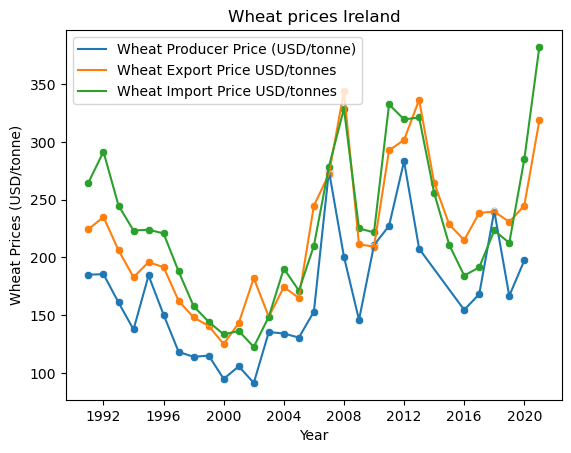

In [62]:
sns.lineplot(data=df_prod_price_pivot, x='Year', y='Wheat Producer Price (USD/tonne)', label='Wheat Producer Price (USD/tonne)')
sns.scatterplot(data=df_prod_price_pivot, x='Year', y='Wheat Producer Price (USD/tonne)')
sns.lineplot(data=df_ml.iloc[30:,-2:], x='Year', y='Wheat Export Price USD/tonnes', label='Wheat Export Price USD/tonnes')
sns.scatterplot(data=df_ml.iloc[30:,-2:], x='Year', y='Wheat Export Price USD/tonnes')
sns.lineplot(data=df_ml.iloc[30:,-2:], x='Year', y='Wheat Import Price USD/tonnes', label='Wheat Import Price USD/tonnes')
sns.scatterplot(data=df_ml.iloc[30:,-2:], x='Year', y='Wheat Import Price USD/tonnes')
plt.ylabel('Wheat Prices (USD/tonne)')
plt.title('Wheat prices Ireland')
plt.legend()
plt.savefig('graphs/wheat_prices_ireland.png', dpi=300, bbox_inches='tight')
plt.show()

Well this shows that import, export and producer price are all strongly correlated and are influenced by global market prices, but the producer price is $\ne$ to the export price so I can't just sub one for the other for the data  I don't have.

For the ML, to simplify things, because I don't have the prices for Irish grown grains sold to Irish commerical feed suppliers, I am just going to use grain import prices to predict meat of chicken export prices. A lot of the grains for poultry feed are imported anyway. 

In [63]:
# keep target variable and then grain import prices
keep_list = ['Meat of chickens, fresh or chilled Export Price USD/tonnes'] 
for column in df_ml.columns.to_list():
    if 'Import Price USD/tonnes' in column:
        keep_list.append(column)

In [64]:
keep_list

['Meat of chickens, fresh or chilled Export Price USD/tonnes',
 'Barley Import Price USD/tonnes',
 'Cake of  soya beans Import Price USD/tonnes',
 'Cake of maize Import Price USD/tonnes',
 'Maize (corn) Import Price USD/tonnes',
 'Meat of chickens, fresh or chilled Import Price USD/tonnes',
 'Poultry meat preparations Import Price USD/tonnes',
 'Soya beans Import Price USD/tonnes',
 'Wheat Import Price USD/tonnes']

In [65]:
df_ML = df_ml[keep_list]

In [66]:
df_ML.head()

,"Meat of chickens, fresh or chilled Export Price USD/tonnes",Barley Import Price USD/tonnes,Cake of soya beans Import Price USD/tonnes,Cake of maize Import Price USD/tonnes,Maize (corn) Import Price USD/tonnes,"Meat of chickens, fresh or chilled Import Price USD/tonnes",Poultry meat preparations Import Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Import Price USD/tonnes
Year,,,,,,,,,
1961-01-01,631.379962,78.345070,84.310618,NaN,54.877621,NaN,NaN,NaN,71.460399
1962-01-01,649.504950,84.852294,89.957265,NaN,54.829257,NaN,NaN,NaN,74.452235
1963-01-01,687.258687,83.178535,96.031965,NaN,60.509857,NaN,NaN,52.631579,73.517144
1964-01-01,537.340619,83.140878,97.576877,NaN,63.153531,882.352941,NaN,NaN,72.831850
1965-01-01,325.732899,68.948735,97.031553,NaN,65.518983,642.857143,NaN,94.827586,68.960709


In [67]:
# oops dont want chicken import prices
df_ML.drop(columns=['Meat of chickens, fresh or chilled Import Price USD/tonnes','Poultry meat preparations Import Price USD/tonnes'], inplace=True)

C:\Users\Juliet\AppData\Local\Temp\ipykernel_5496\292471600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML.drop(columns=['Meat of chickens, fresh or chilled Import Price USD/tonnes','Poultry meat preparations Import Price USD/tonnes'], inplace=True)


In [68]:
df_ML #perf

,"Meat of chickens, fresh or chilled Export Price USD/tonnes",Barley Import Price USD/tonnes,Cake of soya beans Import Price USD/tonnes,Cake of maize Import Price USD/tonnes,Maize (corn) Import Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Import Price USD/tonnes
Year,,,,,,,
1961-01-01,631.379962,78.345070,84.310618,NaN,54.877621,NaN,71.460399
1962-01-01,649.504950,84.852294,89.957265,NaN,54.829257,NaN,74.452235
1963-01-01,687.258687,83.178535,96.031965,NaN,60.509857,52.631579,73.517144
1964-01-01,537.340619,83.140878,97.576877,NaN,63.153531,NaN,72.831850
1965-01-01,325.732899,68.948735,97.031553,NaN,65.518983,94.827586,68.960709
...,...,...,...,...,...,...,...
2017-01-01,1157.823561,184.592839,377.412132,NaN,191.494259,308.400588,191.398972
2018-01-01,1465.101971,238.463551,412.812903,NaN,201.447465,355.056775,223.404317
2019-01-01,1319.164544,232.849476,373.907093,NaN,199.556179,363.177161,212.619814


In [69]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 1961-01-01 to 2021-01-01
Data columns (total 7 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Meat of chickens, fresh or chilled Export Price USD/tonnes  61 non-null     float64
 1   Barley Import Price USD/tonnes                              61 non-null     float64
 2   Cake of  soya beans Import Price USD/tonnes                 61 non-null     float64
 3   Cake of maize Import Price USD/tonnes                       28 non-null     float64
 4   Maize (corn) Import Price USD/tonnes                        61 non-null     float64
 5   Soya beans Import Price USD/tonnes                          54 non-null     float64
 6   Wheat Import Price USD/tonnes                               61 non-null     float64
dtypes: float64(7)
memory usage: 3.8 KB


In [70]:
#cake of maize only has 28 values, 28/61 < 50% so. drop.
df_ML.drop(columns='Cake of maize Import Price USD/tonnes', inplace=True)

C:\Users\Juliet\AppData\Local\Temp\ipykernel_5496\2907218478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML.drop(columns='Cake of maize Import Price USD/tonnes', inplace=True)


In [71]:
df_ML.describe() # i don't know what kind of variance is considered bad for ML models. The means of the features are the same order of magnitude?

,"Meat of chickens, fresh or chilled Export Price USD/tonnes",Barley Import Price USD/tonnes,Cake of soya beans Import Price USD/tonnes,Maize (corn) Import Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Import Price USD/tonnes
count,61.000000,61.000000,61.000000,61.000000,54.000000,61.000000
mean,1302.425730,202.069449,260.716535,189.610087,370.241304,195.892939
std,538.327583,96.687595,118.042761,78.376008,216.182382,82.006932
min,219.780220,48.947943,84.310618,54.829257,52.631579,63.184240
25%,947.160644,141.340289,195.981180,150.941929,263.621170,136.314956
50%,1291.021672,197.857642,241.727373,199.556179,312.380320,210.170924
75%,1567.096199,258.671216,305.736461,245.439045,426.529332,252.784349
max,2636.487286,484.027778,548.254200,319.655610,1333.333333,382.436147


Graphs for correlation

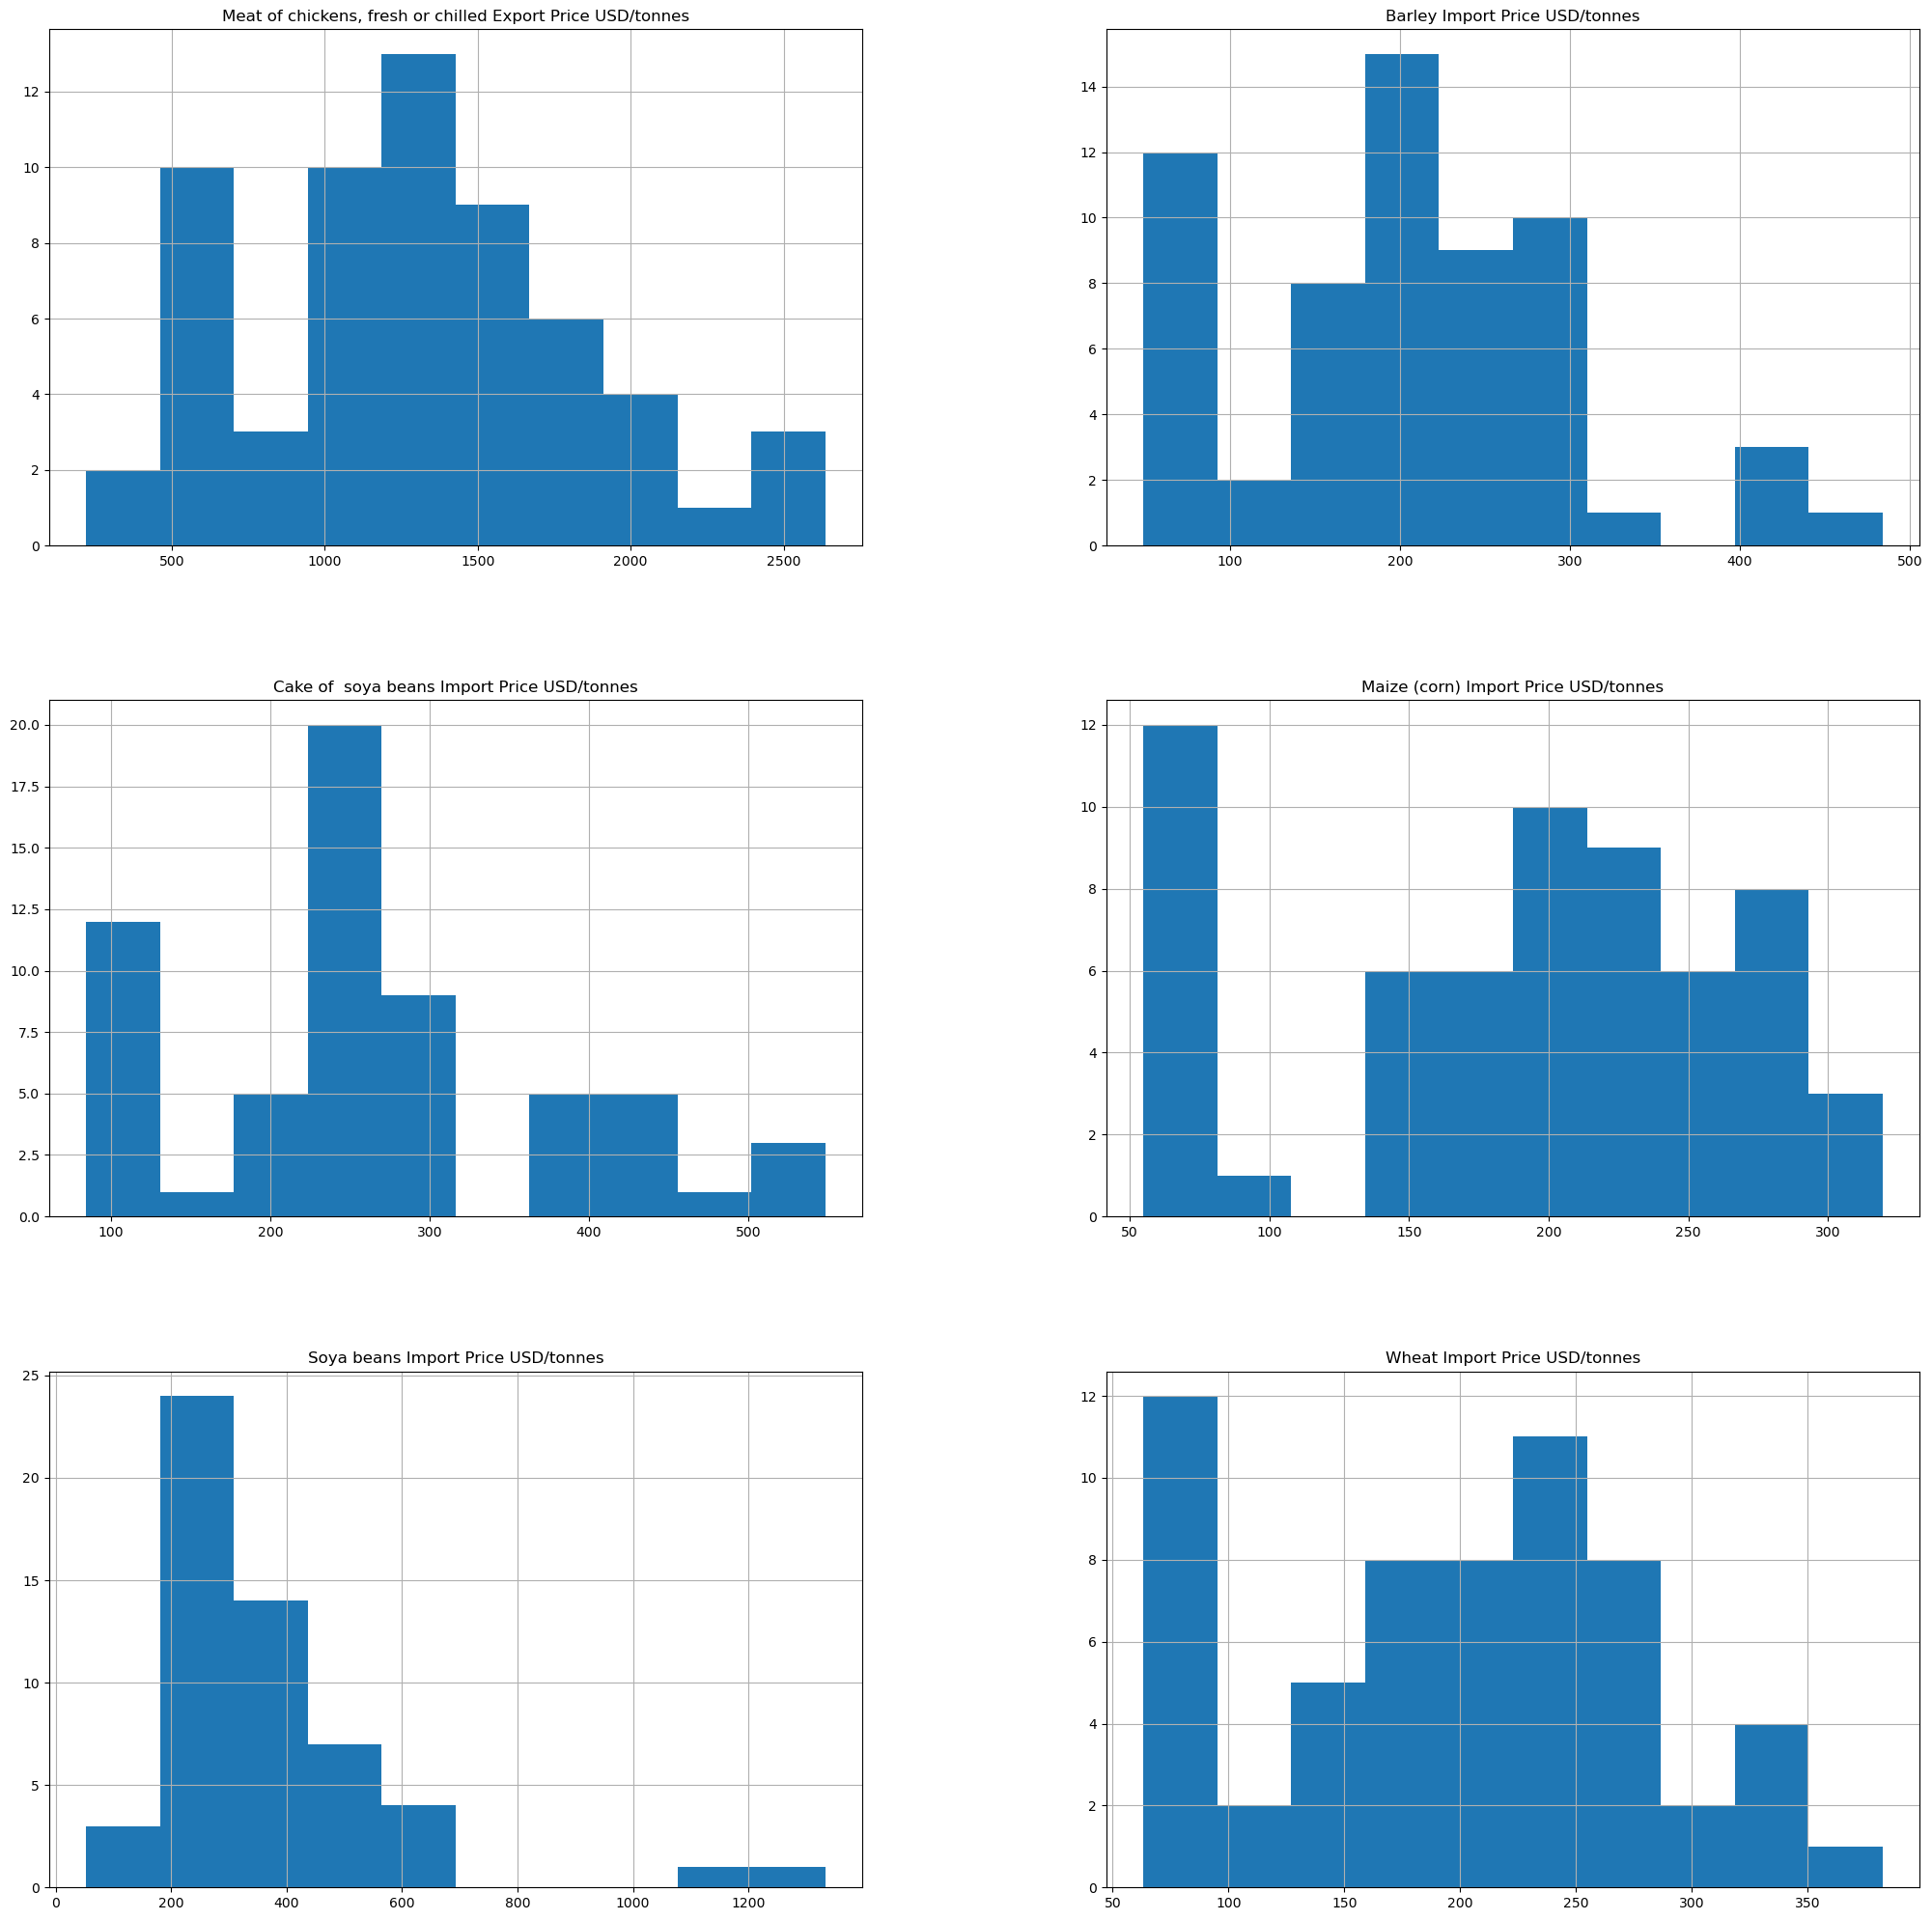

In [72]:
%matplotlib inline
df_ML.hist(figsize=(25,25)); # I should remember to do these graphs more often
#remember. this data is over a range of years. from 1961 to 2021. So the hists might not mean to much.

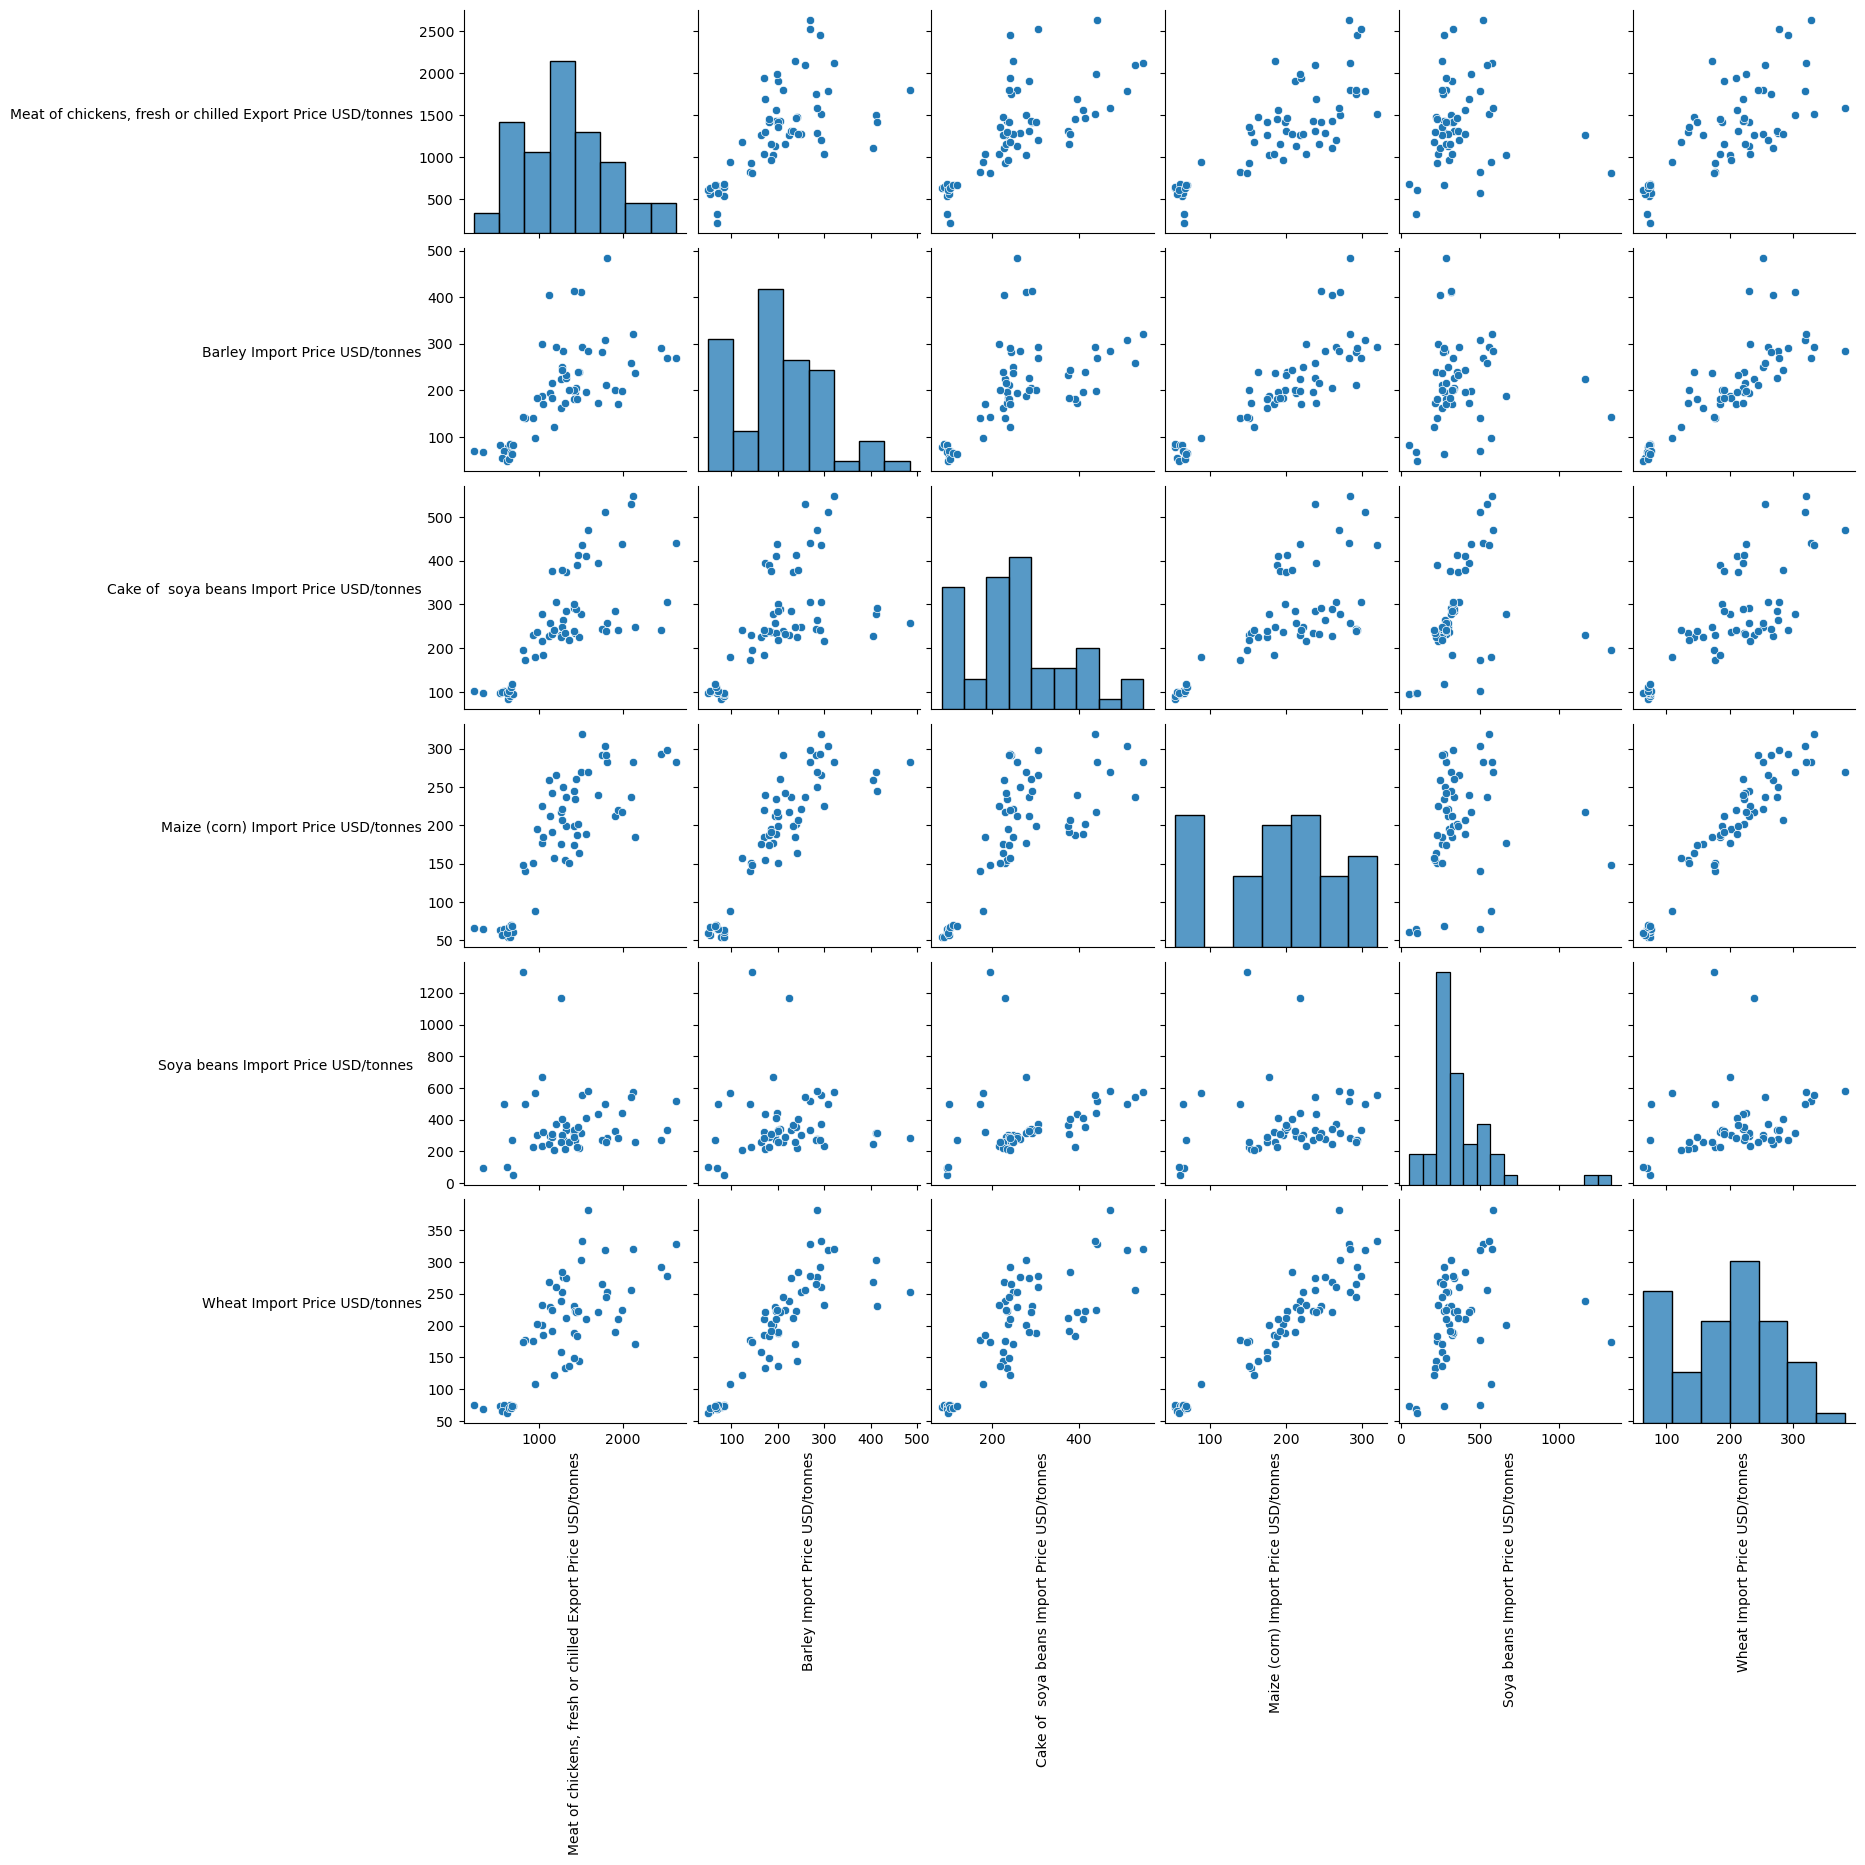

In [73]:
g = sns.pairplot(df_ML)
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

plt.savefig('graphs/ml_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()
# okay now the labels are horrendous in other ways but at least now you can read them

# Maize wheat and barley appear to have a strong correlaion with each other

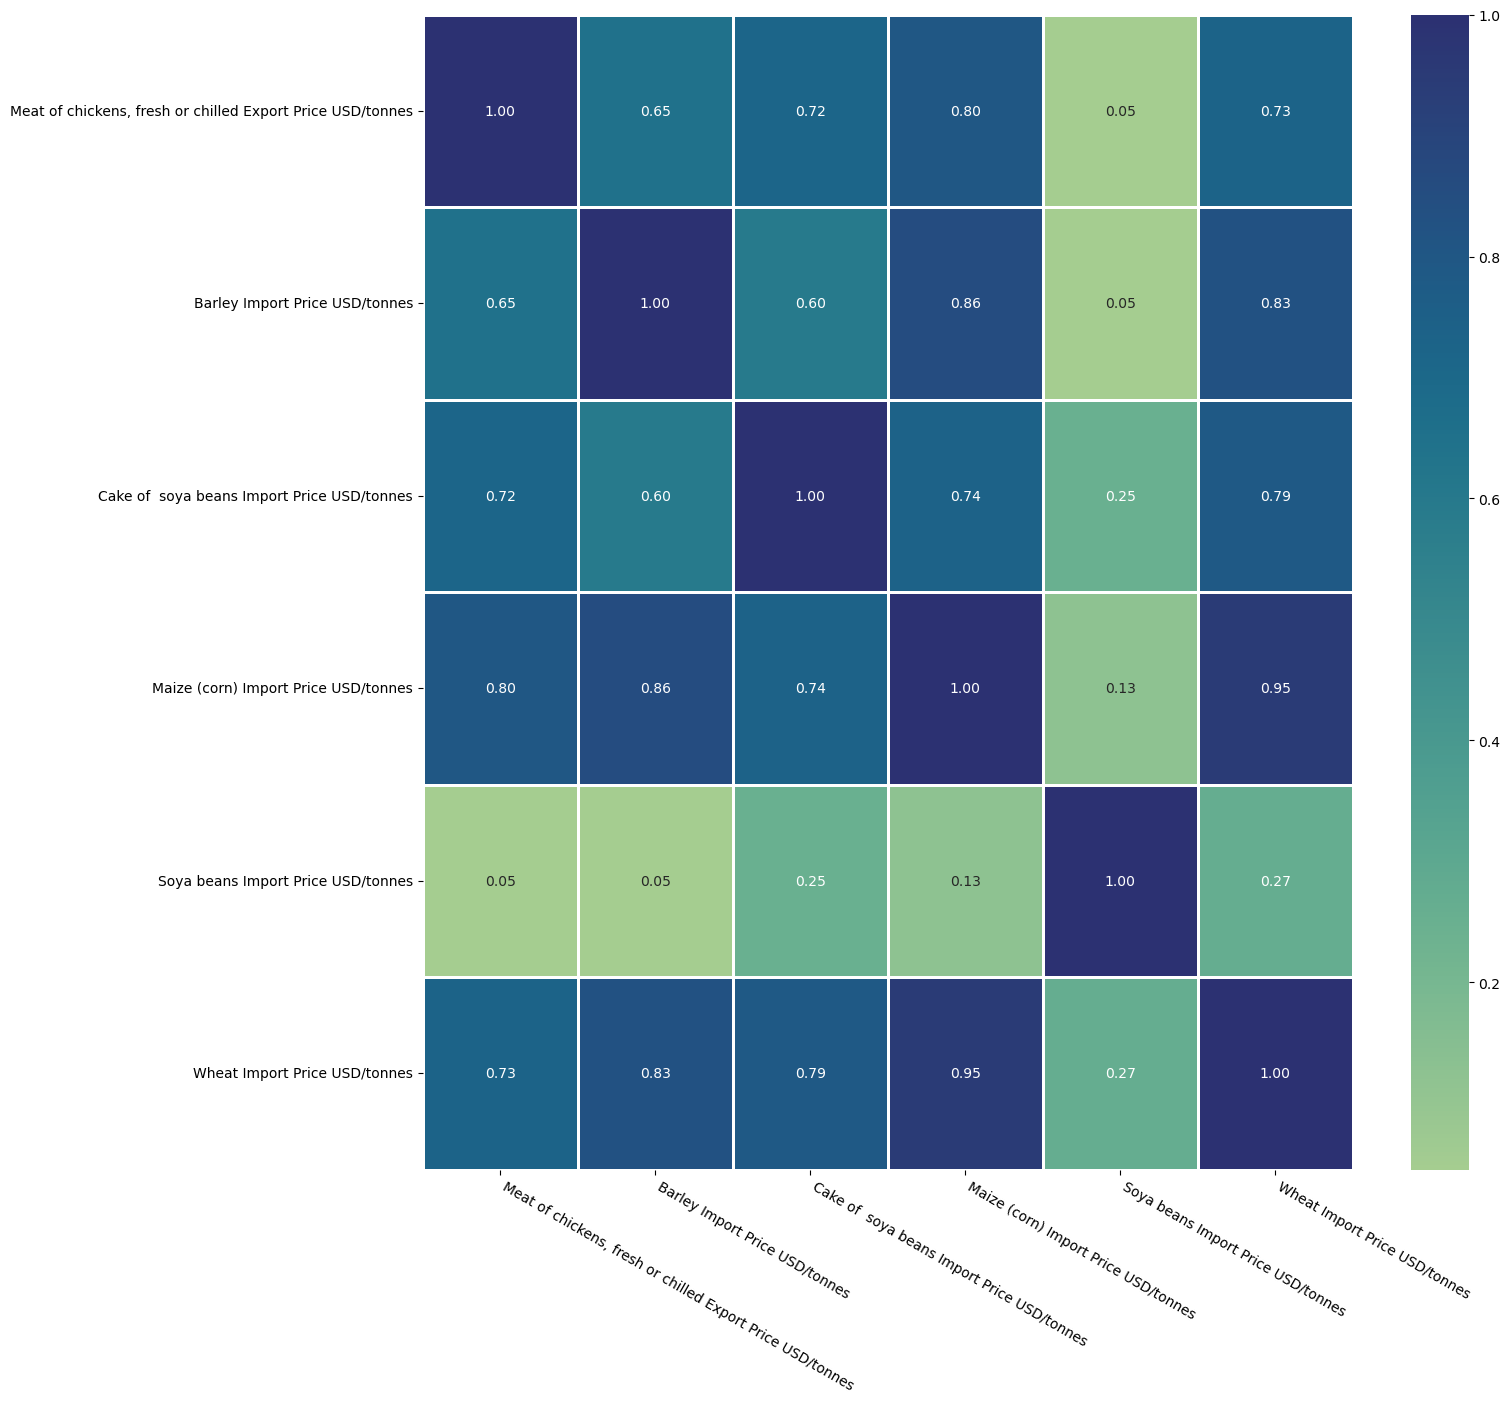

In [74]:
corr_df_ml = df_ML.corr('pearson')

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_df_ml, annot=True, cmap="crest",fmt = '.2f', linewidths = 2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30, ha='left')
#plt.savefig('./graphs/chicken_grain_corr_map.svg', dpi=300, bbox_inches = "tight")
plt.savefig('./graphs/chicken_grain_corr_map.png', dpi=300, bbox_inches = "tight")
plt.show()

Correlation matrix shows some correlation between chicken export prices and some grain import prices, esp cake of soya, maize and wheat.

There appears to be a strong correlation between maize, barley and wheat import prices but we are still going to treat them as independent.

Soya beans have a weak correlation with everything

Possible reasons for correlation?
- Maybe they're subject to the same weather dependencies? Drop in production of one might correlate to a drop a production of the others because bad weather might have a similar impact on all?
- The are all used for animal feed in Ireland (cattle, and others), so they may experience high demand at the same time

Just thoughts.

In [75]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 1961-01-01 to 2021-01-01
Data columns (total 6 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Meat of chickens, fresh or chilled Export Price USD/tonnes  61 non-null     float64
 1   Barley Import Price USD/tonnes                              61 non-null     float64
 2   Cake of  soya beans Import Price USD/tonnes                 61 non-null     float64
 3   Maize (corn) Import Price USD/tonnes                        61 non-null     float64
 4   Soya beans Import Price USD/tonnes                          54 non-null     float64
 5   Wheat Import Price USD/tonnes                               61 non-null     float64
dtypes: float64(6)
memory usage: 3.3 KB


In [76]:
df_ML.describe()

,"Meat of chickens, fresh or chilled Export Price USD/tonnes",Barley Import Price USD/tonnes,Cake of soya beans Import Price USD/tonnes,Maize (corn) Import Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Import Price USD/tonnes
count,61.000000,61.000000,61.000000,61.000000,54.000000,61.000000
mean,1302.425730,202.069449,260.716535,189.610087,370.241304,195.892939
std,538.327583,96.687595,118.042761,78.376008,216.182382,82.006932
min,219.780220,48.947943,84.310618,54.829257,52.631579,63.184240
25%,947.160644,141.340289,195.981180,150.941929,263.621170,136.314956
50%,1291.021672,197.857642,241.727373,199.556179,312.380320,210.170924
75%,1567.096199,258.671216,305.736461,245.439045,426.529332,252.784349
max,2636.487286,484.027778,548.254200,319.655610,1333.333333,382.436147


In [77]:
df_ML = df_ML.fillna(df_ML.mean())

In [78]:
df_ML.describe() #filled soya beans with the mean and it hasn't changed the stats much

,"Meat of chickens, fresh or chilled Export Price USD/tonnes",Barley Import Price USD/tonnes,Cake of soya beans Import Price USD/tonnes,Maize (corn) Import Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Import Price USD/tonnes
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1302.425730,202.069449,260.716535,189.610087,370.241304,195.892939
std,538.327583,96.687595,118.042761,78.376008,203.180772,82.006932
min,219.780220,48.947943,84.310618,54.829257,52.631579,63.184240
25%,947.160644,141.340289,195.981180,150.941929,271.391125,136.314956
50%,1291.021672,197.857642,241.727373,199.556179,325.879840,210.170924
75%,1567.096199,258.671216,305.736461,245.439045,404.224263,252.784349
max,2636.487286,484.027778,548.254200,319.655610,1333.333333,382.436147


## Modelling

#### Create y and X

In [79]:
y = df_ML['Meat of chickens, fresh or chilled Export Price USD/tonnes']
X = df_ML.drop('Meat of chickens, fresh or chilled Export Price USD/tonnes', axis=1)

In [80]:
y.head()

Year
1961-01-01    631.379962
1962-01-01    649.504950
1963-01-01    687.258687
1964-01-01    537.340619
1965-01-01    325.732899
Name: Meat of chickens, fresh or chilled Export Price USD/tonnes, dtype: float64

In [81]:
X.head()

,Barley Import Price USD/tonnes,Cake of soya beans Import Price USD/tonnes,Maize (corn) Import Price USD/tonnes,Soya beans Import Price USD/tonnes,Wheat Import Price USD/tonnes
Year,,,,,
1961-01-01,78.345070,84.310618,54.877621,370.241304,71.460399
1962-01-01,84.852294,89.957265,54.829257,370.241304,74.452235
1963-01-01,83.178535,96.031965,60.509857,52.631579,73.517144
1964-01-01,83.140878,97.576877,63.153531,370.241304,72.831850
1965-01-01,68.948735,97.031553,65.518983,94.827586,68.960709


In [82]:
X.shape, y.shape

((61, 5), (61,))

In [83]:
from scipy.stats.mstats import winsorize
import scipy.stats as stats
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict, KFold, learning_curve)
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tools.eval_measures import mse, rmse
from sklearn import preprocessing

In [84]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [85]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42, 5)
(19, 5)
(42,)
(19,)


In [86]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, len(X_train.columns)+1))}]

alpha = np.arange(0.01,10,0.1)

## Linear Regression

In [87]:
lrm = LinearRegression()   
lrm.fit(X_train, y_train) #fit an OLS model
rfe = RFE(lrm) #apply RFE

# set up GridSearchCV()
lr_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
lr_cv.fit(X_train, y_train)               

# cv results
lrm_cv_results = pd.DataFrame(lr_cv.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


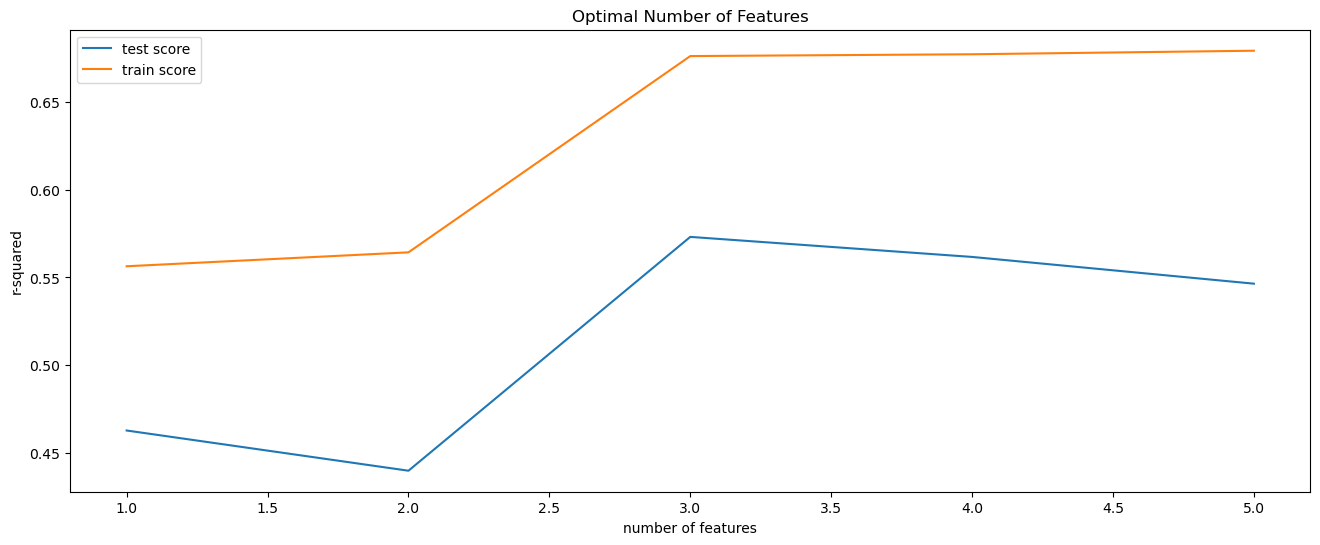

In [88]:
# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(lrm_cv_results["param_n_features_to_select"], lrm_cv_results["mean_test_score"])
plt.plot(lrm_cv_results["param_n_features_to_select"], lrm_cv_results["mean_train_score"])

plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.savefig('./graphs/ML_linear_regression.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
# Making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)  #making predictions

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("The optimal number of features is: {}".format(lr_cv.best_params_))
print("Root mean squared error of the prediction is: {}".format(rmse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.6710505591473162
The optimal number of features is: {'n_features_to_select': 3}
Root mean squared error of the prediction is: 280.7717518890615
-----Test set statistics-----
R-squared of the model in test set is: 0.7258347577784611
Root mean squared error of the prediction is: 322.049868455694
Mean absolute percentage error of the prediction is: 22.860999565376076


## Ridge Regression

In [90]:
# Using GridSearch for parameter optimization
ridgeregr = GridSearchCV(Ridge(),
                         param_grid={'alpha': alpha},
                         scoring= 'r2',
                         cv = folds, 
                         verbose=1,
                         return_train_score=True)

ridgeregr.fit(X_train, y_train)

ridge = ridgeregr.best_estimator_

# cv results
rdg_cv_results = pd.DataFrame(ridgeregr.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


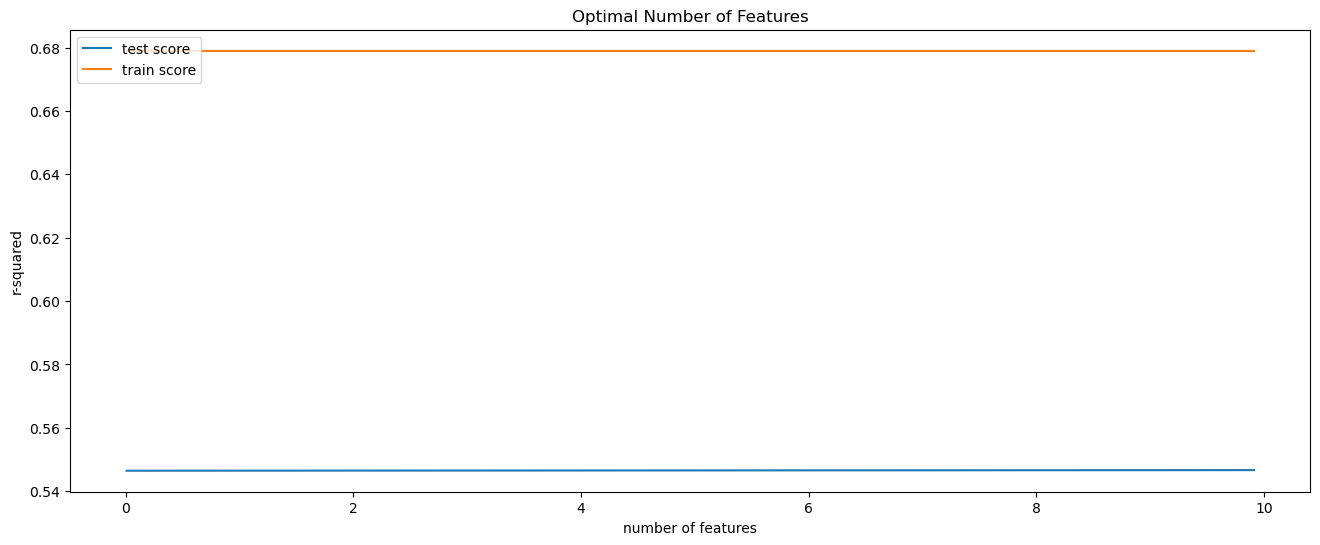

In [91]:
# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(rdg_cv_results["param_alpha"], rdg_cv_results["mean_test_score"])
plt.plot(rdg_cv_results["param_alpha"], rdg_cv_results["mean_train_score"])

plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.savefig('./graphs/ML_ridge_regression.png', dpi=300, bbox_inches='tight')
plt.show()

In [92]:
# Making predictions here
y_preds_train = ridge.predict(X_train)
y_preds_test_ridge = ridge.predict(X_test)

print("R-squared of the model in training set is: {}".format(ridge.score(X_train, y_train)))
print("The optimal value of alpha is: {}".format(ridge.alpha))
print("Root mean squred error of the train set is: {}".format(rmse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_ridge)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_ridge) / y_test)) * 100))

R-squared of the model in training set is: 0.6710505160724836
The optimal value of alpha is: 9.91
Root mean squred error of the train set is: 280.7717702721233
-----Test set statistics-----
R-squared of the model in test set is: 0.7258106214578313
Root mean squared error of the prediction is: 322.06404408158824
Mean absolute percentage error of the prediction is: 22.863526608922786


## Lasso Regression 

In [93]:
# using GridSearch for parameter optimization
lassoregr = GridSearchCV(Lasso(),
                         param_grid={'alpha': alpha},
                         scoring= 'r2',
                         cv = folds, 
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True)

lassoregr.fit(X_train, y_train)

lasso = lassoregr.best_estimator_

# cv results
las_cv_results = pd.DataFrame(lassoregr.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


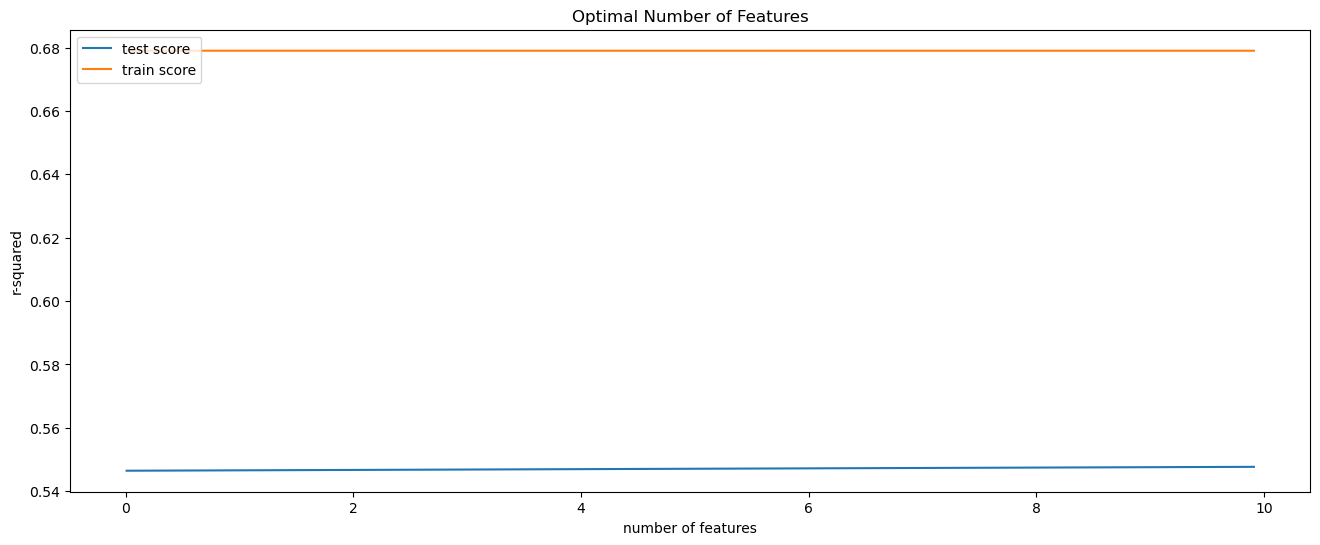

In [94]:
# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(las_cv_results["param_alpha"], las_cv_results["mean_test_score"])
plt.plot(las_cv_results["param_alpha"], las_cv_results["mean_train_score"])

plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.savefig('./graphs/ML_lasso_regression.png', dpi=300, bbox_inches='tight')
plt.show()

In [95]:
# We are making predictions here
y_preds_train = lasso.predict(X_train)
y_preds_test_lasso = lasso.predict(X_test)

print("R-squared of the model in training set is: {}".format(lasso.score(X_train, y_train)))
print("The optimal value of alpha is: {}".format(lasso.alpha))
print("Root mean squred error of the train set is: {}".format(rmse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_lasso)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_lasso) / y_test)) * 100))

R-squared of the model in training set is: 0.6710473540655664
The optimal value of alpha is: 9.91
Root mean squred error of the train set is: 280.77311971966714
-----Test set statistics-----
R-squared of the model in test set is: 0.7257125058376829
Root mean squared error of the prediction is: 322.12166244595124
Mean absolute percentage error of the prediction is: 22.87514308792529


## Decision Tree 

In [96]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,5,9],
           "min_samples_leaf":[2,4,10],
           "max_features":["auto","sqrt",None],
           "max_leaf_nodes":[None,10,30] }

DTregr = GridSearchCV(DecisionTreeRegressor(),
                           param_grid=parameters,
                           scoring= 'r2',
                           cv = folds, 
                           verbose=1,
                           return_train_score=True)


DTregr.fit(X_train, y_train)

DT = DTregr.best_estimator_

# cv results
dt_cv_results = pd.DataFrame(DTregr.cv_results_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [97]:
y_pred_DT = DTregr.predict(X_test)
y_train_DT = DTregr.predict(X_train)

print("R-squared of the model in training set is: {}".format(DTregr.score(X_train, y_train)))
print("Root mean squared error of the training set is: {}".format(rmse(y_train, y_train_DT)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(DTregr.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_pred_DT)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_DT) / y_test)) * 100))

R-squared of the model in training set is: 0.72823375184462
Root mean squared error of the training set is: 255.20348161114455
-----Test set statistics-----
R-squared of the model in test set is: 0.5424909444355935
Root mean squared error of the prediction is: 416.0224579989133
Mean absolute percentage error of the prediction is: 31.44876962517598


## Random Forest

In [98]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}

RFregr = GridSearchCV(RandomForestRegressor(random_state=0),
                           param_grid=parameters,
                           scoring= 'r2',
                           cv = folds, 
                           verbose=1,
                           return_train_score=True)


RFregr.fit(X_train, y_train)

RF = RFregr.best_estimator_

# cv results
rf_cv_results = pd.DataFrame(RFregr.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [99]:
#plot graph??

In [100]:
y_preds_train = RFregr.predict(X_train)
y_pred_random = RFregr.predict(X_test)

print("R-squared of the model in training set is: {}".format(RFregr.score(X_train, y_train)))
print("Root mean squred error of the train set is: {}".format(rmse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(RFregr.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_pred_random)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_random) / y_test)) * 100))

R-squared of the model in training set is: 0.8565890040143649
Root mean squred error of the train set is: 185.38733506803678
-----Test set statistics-----
R-squared of the model in test set is: 0.6807216412294541
Root mean squared error of the prediction is: 347.5374974403388
Mean absolute percentage error of the prediction is: 27.74566658828374


The best models are the linear regression models, LinearRegression, RidgeRegression and LassoRegression, who all perform the same after tuning of hyperparameters.